# Testing the code on simulated noise with change points

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code when running on fake Gaussian noise.

In this notebook we give three different situations showing the extreme pathologies when running the nested sampling code (`lalapps_pulsar_parameter_estimation_nested`) with its ability to find data change points, compared to running in the legacy mode with the implicit assumption that the data is stationary on 30 minute timescales. In all cases we have a 60 point data set containing Gaussian noise: in the the first case the Gaussian noise has two different variances, with two change points one quarter (point 15) and three quarters (point 45) through the data set; in the second case there is only one change point halfway through the dataset (point 30); and in the final case the data will just consist of Gaussian noise with a single variance, i.e. no change points. In the first case the old `lalapps_pulsar_parameter_estimation` will split the data in two equally and think that each chunk is stationary, when in fact they are not stationary.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
from scipy.stats import hmean
import subprocess as sp
import os
import sys
from time import time
import matplotlib as mpl
from matplotlib import pyplot as pl

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

mpl.rcParams.update(mplparams)

In [2]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'local' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')
#execpath = '/opt/lscsoft/bin'

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
ppeexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation')

## Running the codes

The code is run on random Gaussian noise with zero mean and two given standard deviations: one for the fisrt and final quarters of the data and another for the middle two quarters. I output a comparison plot between the posteriors produced for each realisation. I compare the upper limit produced from the nested-sampling-generated posterior and that calculated from the grid-based posterior. I also compare the run times for each implementation of the codes.

In [3]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {}
DECJ {}
F0 123.4567890
PEPOCH 56789.0
EPHEM DE405
"""

# some defaults for the data generation
sigmas = [1.0e-22, 5.0e-22]        # set data standard deviations
dt = 1000              # number of seconds between data points
gpsstart = 900000000   # GPS start time of data
duration = dt*60       # duration of data (seconds) - 10 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(hmean(sigmas)**2/dlen)

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# (PHI0 in here is rotational phase, whereas for the older code it is GW phase for trixial emission l=m=2)
priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform {} {}
COSIOTA uniform -1 1
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 12 times the expected upper limit 
fp.write(priordat.format(ulest*12., np.pi, -np.pi/4., np.pi/4.))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '4096' # number of nested sample live points

h0ulc = '95'                # % credible h0 upper limit to output

## Case 1 (two change points)

In [4]:
# CASE 1 (two change points)

# create data
data = sigmas[0]*np.random.randn(dlen, 2)
data[int(dlen/4):int(3*dlen/4),:] = (sigmas[1]/sigmas[0])*data[int(dlen/4):int(3*dlen/4),:]

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
# create a random sky position from a uniform distribution on the sky
rah, ram, ras = rad_to_hms(2.*np.pi*np.random.rand())
decd, decm, decs = rad_to_dms(np.arccos(-1.+2.*np.random.rand()) - np.pi/2.)
    
# output .par file containing right ascension and declination
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), coord_to_string(decd, decm, decs)))
fp.close()

chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
if os.path.isfile(chunksfile):
    os.remove(chunksfile)

# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get the change points
chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
fp = open(chunksfile, 'r')
chunkslines = [cl.strip() for cl in fp.readlines() if len(cl.strip()) is not 0]
fp.close()
print("Data was split into %d chunks at indices:" % len(chunkslines))
for cline in chunkslines[:-1]:
    print('%s' % (cline.split())[0])
print("Change points were at indices %d and %d" % (int(dlen/4), int(3*dlen/4)))

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post1.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post1.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))
    
h0ulnested = (h0ul)
evratnested = (evsig-evnoise)

# run lalapps_pulsar_parameter_estimation_nested (with legacy data segmentation turned on)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks', '--oldChunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post2.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post2.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))

h0ulnested2 = (h0ul)
evratnested2 = (evsig-evnoise)

Data was split into 3 chunks at indices:
15
44
Change points were at indices 15 and 45
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']


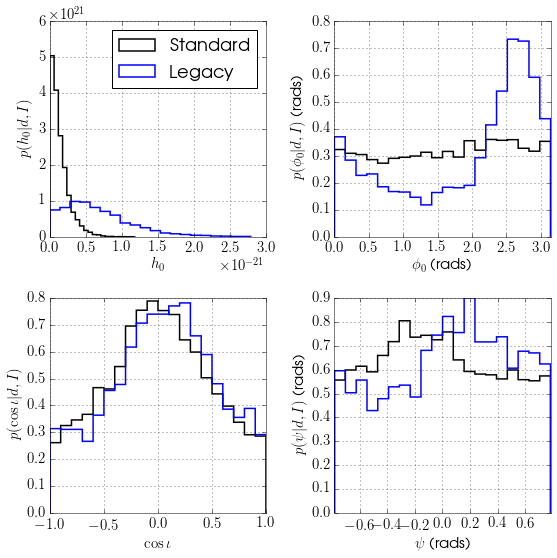

In [5]:
f, axarr = pl.subplots(2, 2, figsize=(8,8))

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen1 = np.loadtxt(os.path.join(outdir, 'fake_post1.txt.gz'), skiprows=1)
postppen2 = np.loadtxt(os.path.join(outdir, 'fake_post2.txt.gz'), skiprows=1)
ppenidxs = {'h0': 1, 'phi': 2, 'ciota': 0, 'psi': 3}

xlabels = {'h0': '$h_0$', 'phi': '$\phi_0$ (rads)', 'ciota': '$\cos{\iota}$', 'psi': '$\psi$ (rads)'}
ylabels = {'h0': '$p(h_0|d,I)$', 'phi': '$p(\phi_0|d,I)$ (rads)', 'ciota': '$p(\cos{\iota}|d,I)$', 'psi': '$p(\psi|d,I)$ (rads)'}

arr = {'h0': axarr[0, 0], 'phi': axarr[0,1], 'ciota': axarr[1,0], 'psi': axarr[1,1]}
lims = {'h0': [0., None], 'phi': [0., np.pi], 'ciota': [-1., 1.], 'psi': [-np.pi/4., np.pi/4.]}
for par in ['h0', 'phi', 'psi', 'ciota']:
    arr[par].hist(postppen1[:,ppenidxs[par]], bins=20, normed=True, color='k', linewidth=1.5, histtype='step')
    arr[par].hist(postppen2[:,ppenidxs[par]], bins=20, normed=True, color='b', linewidth=1.5, histtype='step')

    arr[par].set_xlabel(xlabels[par])
    arr[par].set_ylabel(ylabels[par])

    if par == 'h0':
        arr[par].legend(['Standard', 'Legacy'], loc=1)
        xmin, xmax = arr[par].get_xlim()
        arr[par].set_xlim([lims[par][0], xmax])
    else:
        arr[par].set_xlim(lims[par])

pl.tight_layout()

In [6]:
print("Difference in upper limits:")
print("h0 upper limit (nested) = %.2e" % h0ulnested)
print("h0 upper limit (nested legacy) = %.2e" % h0ulnested2)
print("percentage difference = %.2f" % (100.*np.abs(h0ulnested-h0ulnested2)/h0ulnested))
print("\n")
print("Difference in evidence ratios:")
print("log(evidence ratio) (nested) = %.2e" % evratnested)
print("log(evidence ratio) (nested legacy) = %.2e" % evratnested2)
print("absolute difference = %.2f" % (np.abs(evratnested-evratnested2)))

Difference in upper limits:
h0 upper limit (nested) = 3.98e-22
h0 upper limit (nested legacy) = 1.57e-21
percentage difference = 295.80


Difference in evidence ratios:
log(evidence ratio) (nested) = -2.72e+00
log(evidence ratio) (nested legacy) = -6.27e-01
absolute difference = 2.09


## Case 2 (one change point)

In [7]:
# CASE 2 (one change points)

# create data
data = np.random.randn(dlen, 2)
data[0:int(dlen/2)] = sigmas[0]*data[0:int(dlen/2)]
data[int(dlen/2):] = sigmas[1]*data[int(dlen/2):]

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')

chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
if os.path.isfile(chunksfile):
    os.remove(chunksfile)

# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get the change points
chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
fp = open(chunksfile, 'r')
chunkslines = [cl.strip() for cl in fp.readlines() if len(cl.strip()) is not 0]
fp.close()
print("Data was split into %d chunks at indices:" % len(chunkslines))
for cline in chunkslines[:-1]:
    print('%s' % (cline.split())[0])
print("Change points was at index %d" % (int(dlen/2)))

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post1.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post1.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))
    
h0ulnested = (h0ul)
evratnested = (evsig-evnoise)

# run lalapps_pulsar_parameter_estimation_nested (with legacy data segmentation turned on)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks', '--oldChunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post2.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post2.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))

h0ulnested2 = (h0ul)
evratnested2 = (evsig-evnoise)

Data was split into 2 chunks at indices:
31
Change points was at index 30
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']


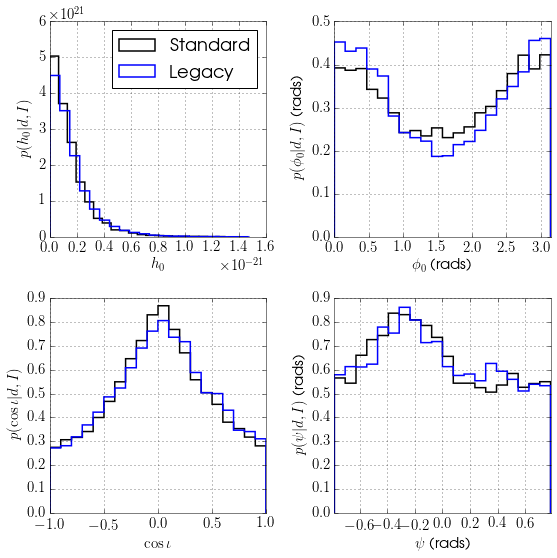

In [8]:
f, axarr = pl.subplots(2, 2, figsize=(8,8))

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen1 = np.loadtxt(os.path.join(outdir, 'fake_post1.txt.gz'), skiprows=1)
postppen2 = np.loadtxt(os.path.join(outdir, 'fake_post2.txt.gz'), skiprows=1)

arr = {'h0': axarr[0, 0], 'phi': axarr[0,1], 'ciota': axarr[1,0], 'psi': axarr[1,1]}
for par in ['h0', 'phi', 'psi', 'ciota']:
    arr[par].hist(postppen1[:,ppenidxs[par]], bins=20, normed=True, color='k', linewidth=1.5, histtype='step')
    arr[par].hist(postppen2[:,ppenidxs[par]], bins=20, normed=True, color='b', linewidth=1.5, histtype='step')

    arr[par].set_xlabel(xlabels[par])
    arr[par].set_ylabel(ylabels[par])

    if par == 'h0':
        arr[par].legend(['Standard', 'Legacy'], loc=1)
        xmin, xmax = arr[par].get_xlim()
        arr[par].set_xlim([lims[par][0], xmax])
    else:
        arr[par].set_xlim(lims[par])

pl.tight_layout()

In [9]:
print("Difference in upper limits:")
print("h0 upper limit (nested) = %.2e" % h0ulnested)
print("h0 upper limit (nested legacy) = %.2e" % h0ulnested2)
print("percentage difference = %.2f" % (100.*np.abs(h0ulnested-h0ulnested2)/h0ulnested))
print("\n")
print("Difference in evidence ratios:")
print("log(evidence ratio) (nested) = %.2e" % evratnested)
print("log(evidence ratio) (nested legacy) = %.2e" % evratnested2)
print("absolute difference = %.2f" % (np.abs(evratnested-evratnested2)))

Difference in upper limits:
h0 upper limit (nested) = 4.34e-22
h0 upper limit (nested legacy) = 4.69e-22
percentage difference = 8.14


Difference in evidence ratios:
log(evidence ratio) (nested) = -2.65e+00
log(evidence ratio) (nested legacy) = -2.57e+00
absolute difference = 0.08


In this case we see that, as would be expected, both codes find the same answer as the data was split in almost the same way.

## Case 3 (no change points)

In [10]:
# CASE 3 (no change points)

# create data
data = sigmas[0]*np.random.randn(dlen, 2)

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')

chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
if os.path.isfile(chunksfile):
    os.remove(chunksfile)

# run lalapps_pulsar_parameter_estimation_nested
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get the change points
chunksfile = os.path.join(rundir, detector+'data_segment_list.txt')
fp = open(chunksfile, 'r')
chunkslines = [cl.strip() for cl in fp.readlines() if len(cl.strip()) is not 0]
fp.close()
print("Data was split into %d chunks at indices:" % len(chunkslines))
for cline in chunkslines[:-1]:
    print('%s' % (cline.split())[0])
print("There were no change points was at index")

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post1.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post1.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))
    
h0ulnested = (h0ul)
evratnested = (evsig-evnoise)

# run lalapps_pulsar_parameter_estimation_nested (with legacy data segmentation turned on)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfile, '--prior-file', priorfile,
                     '--input-files', datafile, '--outfile', os.path.join(outdir, 'fake_nest.txt'),
                     '--gzip', '--Nlive', Nlive, '--Nmcmcinitial', '0', '--output-chunks', '--oldChunks'])

p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# nested samples need to be converted to posterior samples with lalapps_nest2pos
codecall = ' '.join([n2pexec, '--Nlive', Nlive, '-p', os.path.join(outdir, 'fake_post2.txt'),
                     '-H', os.path.join(outdir, 'fake_nest.txt_params.txt'), '-z',
                     os.path.join(outdir, 'fake_nest.txt.gz')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
    
# get h0 upper limit from 
post, evsig, evnoise = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post2.txt.gz'))
h0ul = upper_limit_greedy(post['h0'].samples, upperlimit=(float(h0ulc)/100.))

h0ulnested2 = (h0ul)
evratnested2 = (evsig-evnoise)

Data was split into 1 chunks at indices:
There were no change points was at index
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']
acosing cosiota
Read columns ['iota', 'h0', 'phi0', 'psi', 'deltalogl', 'deltaloglh1', 'logl', 'logprior', 'logw']


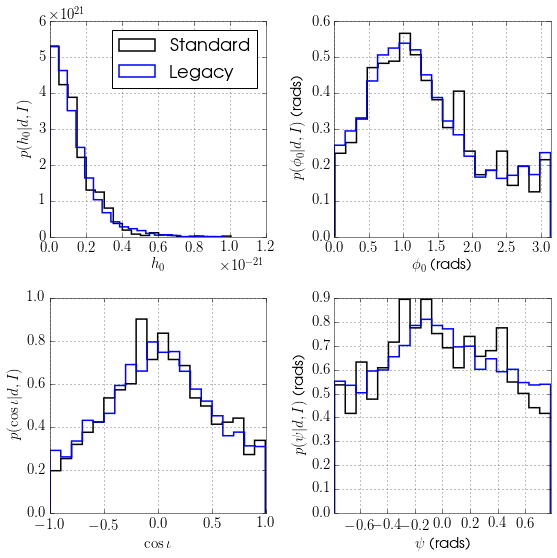

In [11]:
f, axarr = pl.subplots(2, 2, figsize=(8,8))

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppen1 = np.loadtxt(os.path.join(outdir, 'fake_post1.txt.gz'), skiprows=1)
postppen2 = np.loadtxt(os.path.join(outdir, 'fake_post2.txt.gz'), skiprows=1)

arr = {'h0': axarr[0, 0], 'phi': axarr[0,1], 'ciota': axarr[1,0], 'psi': axarr[1,1]}
for par in ['h0', 'phi', 'psi', 'ciota']:
    arr[par].hist(postppen1[:,ppenidxs[par]], bins=20, normed=True, color='k', linewidth=1.5, histtype='step')
    arr[par].hist(postppen2[:,ppenidxs[par]], bins=20, normed=True, color='b', linewidth=1.5, histtype='step')

    arr[par].set_xlabel(xlabels[par])
    arr[par].set_ylabel(ylabels[par])

    if par == 'h0':
        arr[par].legend(['Standard', 'Legacy'], loc=1)
        xmin, xmax = arr[par].get_xlim()
        arr[par].set_xlim([lims[par][0], xmax])
    else:
        arr[par].set_xlim(lims[par])

pl.tight_layout()

In [12]:
print("Difference in upper limits:")
print("h0 upper limit (nested) = %.2e" % h0ulnested)
print("h0 upper limit (nested legacy) = %.2e" % h0ulnested2)
print("percentage difference = %.2f" % (100.*np.abs(h0ulnested-h0ulnested2)/h0ulnested))
print("\n")
print("Difference in evidence ratios:")
print("log(evidence ratio) (nested) = %.2e" % evratnested)
print("log(evidence ratio) (nested legacy) = %.2e" % evratnested2)
print("absolute difference = %.2f" % (np.abs(evratnested-evratnested2)))

Difference in upper limits:
h0 upper limit (nested) = 3.46e-22
h0 upper limit (nested legacy) = 3.77e-22
percentage difference = 8.96


Difference in evidence ratios:
log(evidence ratio) (nested) = -2.74e+00
log(evidence ratio) (nested legacy) = -2.75e+00
absolute difference = 0.01


There is very little difference between these as the Student's _t_-likelihood functions for both have relatively large degrees of freedom, which means they both well approximate a Gaussian.

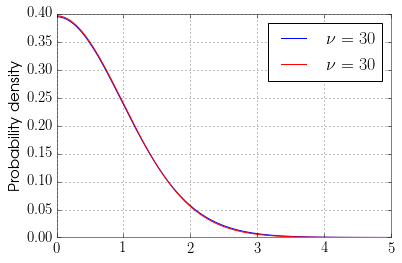

In [13]:
from scipy.stats import t
x = np.linspace(0, 5, 1000)

# 30 degrees of freedom
thirty = t.pdf(x, 30)

# 60 degrees of freedom
sixty = t.pdf(x, 60)

pl.plot(x, thirty, 'b', label='$\\nu = 30$')
pl.plot(x, sixty, 'r', label='$\\nu = 30$')
pl.ylabel('Probability density')
pl.legend()